<a href="https://colab.research.google.com/github/d9249/DACON/blob/main/densenet169%20Train%2BInference%20(ImageNet%20statistics%2C%20pretrained%2C%20full).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Oct 10 14:21:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/MyDrive/DACON_2021_recognize_traffic_signal_motion/new_open.zip" -d "/content/"

In [ ]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import torch, torchvision
import torchvision.transforms as transforms
import os, json, PIL
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

In [ ]:
def count(output, target):
    with torch.no_grad():
        predict = torch.argmax(output, 1)
        correct = (predict == target).sum().item()
        return correct

def select_model(model, num_classes):
    if model == 'resnet18':
        model_ = models.resnet18(pretrained=True)
        model_.fc = nn.Linear(512, num_classes)
    elif model == 'resnet34':
        model_ = models.cc(pretrained=True)
        model_.fc = nn.Linear(512, num_classes)
    elif model == 'resnet50':
        model_ = models.resnet50(pretrained=True)
        model_.fc = nn.Linear(2048, num_classes)
    elif model == 'resnet101':
        model_ = models.resnet101(pretrained=True)
        model_.fc = nn.Linear(2048, num_classes)
    elif model == 'resnet152':
        model_ = models.resnet152(pretrained=True)
        model_.fc = nn.Linear(2048, num_classes)
    elif model == 'densenet121':
        model_ = models.densenet121(pretrained=True)
        model_.classifier = nn.Linear(1024, num_classes)
    elif model == 'densenet169':
        model_ = models.densenet169(pretrained=True)
        model_.classifier = nn.Linear(1664, num_classes)
    elif model == 'densenet201':
        model_ = models.densenet201(pretrained=True)
        model_.classifier = nn.Linear(1920, num_classes)
    elif model == 'densenet161':
        model_ = models.densenet161(pretrained=True)
        model_.classifier = nn.Linear(2208, num_classes)
    elif model == 'inception_v3':
        model_ = models.inception_v3(pretrained=True)
        model_.fc = nn.Linear(512, num_classes)
    elif model == 'googlenet':
        model_ = models.googlenet(pretrained=True)
        model_.fc = nn.Linear(1024, num_classes)
    elif model == 'shufflenet_v2_x1_0':
        model_ = models.shufflenet_v2_x1_0(pretrained=True)
        model_.fc = nn.Linear(1024, num_classes)
    elif model == 'alexnet':
        model_ = models.alexnet(pretrained=True)
        model_.fc = nn.Linear(512, num_classes)
    elif model == 'squeezenet1_0':
        model_ = models.squeezenet1_0(pretrained=True)
        model_.fc = nn.Linear(512, num_classes)
    elif model == 'squeezenet1_1':
        model_ = models.squeezenet1_1(pretrained=True)
        model_.fc = nn.Linear(512, num_classes)
    elif model == 'vgg11':
        model_ = models.vgg11(pretrained=True)
        model_.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(4096, num_classes, bias=True),
        )
    elif model == 'vgg13':
        model_ = models.vgg13(pretrained=True)
        model_.classifier = nn.Linear(25088, num_classes)
    elif model == 'vgg16':
        model_ = models.vgg16(pretrained=True)
        model_.classifier = nn.Linear(25088, num_classes)
    elif model == 'vgg19':
        model_ = models.vgg19(pretrained=True)
        model_.classifier = nn.Linear(25088, num_classes)
    return model_

class Baseline():
    def __init__(self, model, num_classes, gpu_id=0, epoch_print=1, print_freq=10, save=False):
        self.gpu = gpu_id
        self.epoch_print = epoch_print
        self.print_freq = print_freq
        self.save = save

        torch.cuda.set_device(self.gpu)

        self.loss_function = nn.CrossEntropyLoss().cuda(self.gpu)

        model = select_model(model, num_classes)
        self.model = model.cuda(self.gpu)

        self.train_losses, self.test_losses = [], []
        self.train_acc, self.test_acc = [], []
        self.best_acc = None
        self.best_loss = None

    def train(self, train_data, test_data, epochs=100, lr=0.1, weight_decay=0.0001):
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr, weight_decay=weight_decay)
        
        for epoch in range(epochs):
            if epoch % self.epoch_print == 0: print('Epoch {} Started...'.format(epoch+1))
            for i, (X, y) in enumerate(train_data):
                X, y = X.cuda(self.gpu), y.cuda(self.gpu)
                output = self.model(X)
                loss = self.loss_function(output, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (epoch % self.epoch_print == 0) and (i % self.print_freq == 0):
                    train_acc = 100 * count(output, y) / y.size(0)
                    test_acc, test_loss = self.test(test_data)
                    
                    if self.save and ((self.best_acc == None) or (self.best_acc < test_acc) or (test_loss < self.best_loss)):
                        torch.save(self.model.state_dict(), '{}_{}.pt'.format(epoch, i))
                        self.best_acc = test_acc
                        self.best_loss = test_loss
                        print('Best Model Saved')

                    self.train_losses.append(loss.item())
                    self.train_acc.append(train_acc)
                    self.test_losses.append(test_loss)
                    self.test_acc.append(test_acc)

                    print('Iteration : {} - Train Loss : {:.6f}, Test Loss : {:.6f}, '
                          'Train Acc : {:.6f}, Test Acc : {:.6f}'.format(i+1, loss.item(), test_loss, train_acc, test_acc))
            print()

    def test(self, test_data):
        correct, total = 0, 0
        losses = []

        self.model.eval()
        with torch.no_grad():
            for i, (X, y) in enumerate(test_data):
                X, y = X.cuda(self.gpu), y.cuda(self.gpu)
                output = self.model(X)

                loss = self.loss_function(output, y)
                losses.append(loss.item())
                
                correct += count(output, y)
                total += y.size(0)
        self.model.train()
        return (100*correct/total, sum(losses)/len(losses))

In [ ]:
data_dir = './train/'
imgs, labels = [], []
for num in sorted(os.listdir(data_dir)):
    with open(data_dir + '{}/{}.json'.format(num, num), 'r') as j:
        temp = json.load(j)
        for info in temp['annotations']:
            imgs.append(data_dir + '{}/{}.png'.format(num, info['image_id']))
            labels.append(temp['action'][0])

label_info = {label:i for i, label in enumerate(sorted(set(labels)))}
train_imgs, val_imgs, train_labels, val_labels = train_test_split(imgs, labels, random_state=0, stratify=labels)

class TrainDataset(Dataset):
    def __init__(self, transform=None):
        self.imgs = train_imgs
        self.labels = train_labels
        self.label_info = label_info
        self.transform = transform

    def __getitem__(self, idx):
        img = PIL.Image.open(self.imgs[idx]).convert('RGB')
        if self.transform: img = self.transform(img)

        label = self.label_info[self.labels[idx]]
        return img, label

    def __len__(self):
        return len(self.imgs)
    
class ValDataset(Dataset):
    def __init__(self, transform=None):
        self.imgs = val_imgs
        self.labels = val_labels
        self.label_info = label_info
        self.transform = transform

    def __getitem__(self, idx):
        img = PIL.Image.open(self.imgs[idx]).convert('RGB')
        if self.transform: img = self.transform(img)

        label = self.label_info[self.labels[idx]]
        return img, label

    def __len__(self):
        return len(self.imgs)

In [ ]:
batch_size = 32

train_transform = transforms.Compose([
    transforms.Resize(256), transforms.RandomCrop((224, 400)),
    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop((224, 400)),
    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
train_dataset = TrainDataset(transform=train_transform)
val_dataset = ValDataset(transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = Baseline(model='densenet169', num_classes=len(train_dataset.label_info), print_freq=5, save=True)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]

In [ ]:
epochs = 5
lr = 0.0005
weight_decay = 0.00001

In [11]:
model.train(train_loader, val_loader, epochs=epochs, lr=lr, weight_decay=weight_decay)

Epoch 1 Started...
Best Model Saved
Iteration : 1 - Train Loss : 5.075229, Test Loss : 5.045974, Train Acc : 0.000000, Test Acc : 4.551630
Best Model Saved
Iteration : 6 - Train Loss : 4.850998, Test Loss : 4.992685, Train Acc : 6.250000, Test Acc : 4.755435
Best Model Saved
Iteration : 11 - Train Loss : 4.667337, Test Loss : 4.707370, Train Acc : 6.250000, Test Acc : 8.152174
Best Model Saved
Iteration : 16 - Train Loss : 4.079946, Test Loss : 4.163793, Train Acc : 18.750000, Test Acc : 17.934783
Best Model Saved
Iteration : 21 - Train Loss : 3.478866, Test Loss : 3.845726, Train Acc : 34.375000, Test Acc : 20.312500
Best Model Saved
Iteration : 26 - Train Loss : 3.525275, Test Loss : 3.530835, Train Acc : 28.125000, Test Acc : 22.146739
Best Model Saved
Iteration : 31 - Train Loss : 3.488333, Test Loss : 3.240046, Train Acc : 21.875000, Test Acc : 28.532609
Best Model Saved
Iteration : 36 - Train Loss : 3.054126, Test Loss : 3.039892, Train Acc : 40.625000, Test Acc : 32.404891
Best 

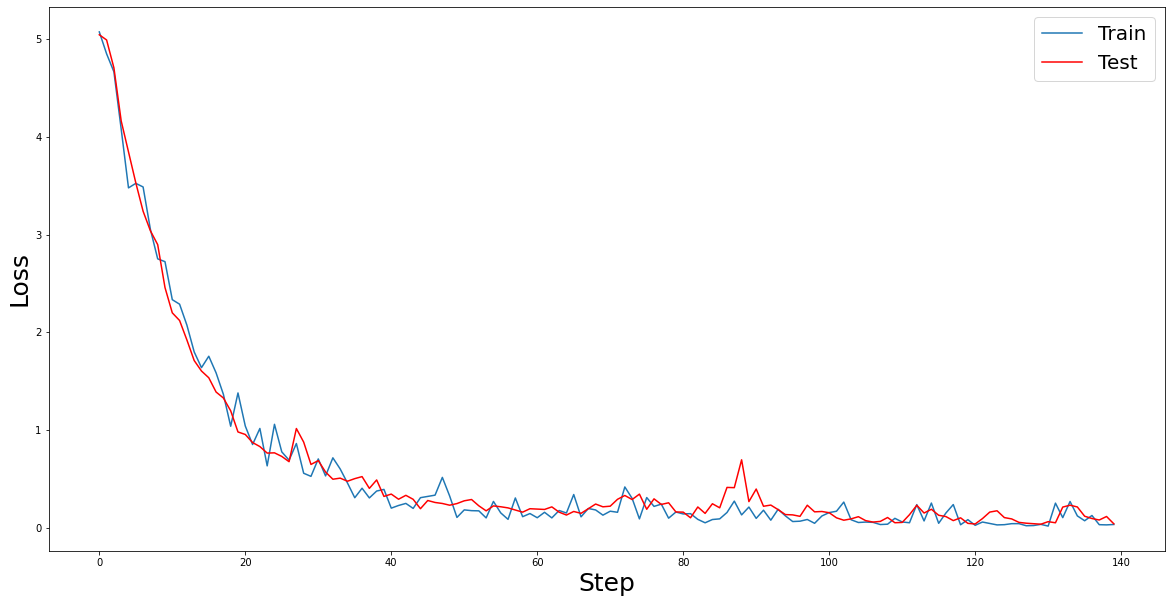

In [12]:
label_fontsize = 25

plt.figure(figsize=(20, 10))
train_lossline, = plt.plot(model.train_losses, label='Train')
test_lossline, = plt.plot(model.test_losses, color='red', label='Test')
plt.legend(handles=[train_lossline, test_lossline], fontsize=20)
plt.xlabel('Step', fontsize=label_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)
plt.show()

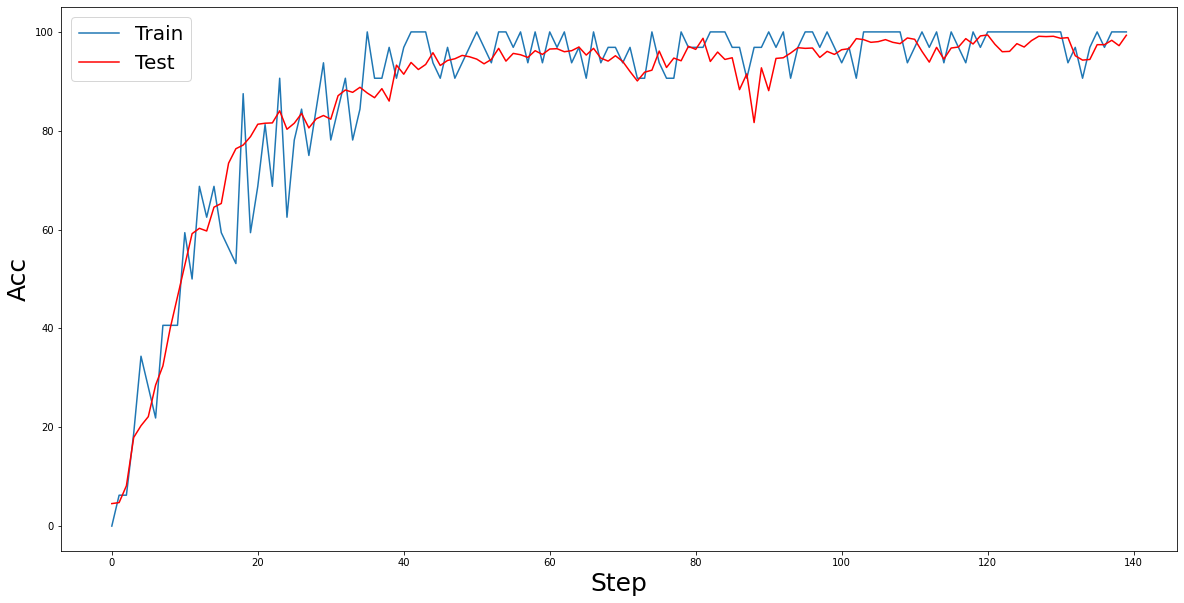

In [13]:
plt.figure(figsize=(20, 10))
train_accline, = plt.plot(model.train_acc, label='Train')
test_accline, = plt.plot(model.test_acc, color='red', label='Test')
plt.legend(handles=[train_accline, test_accline], fontsize=20)
plt.xlabel('Step', fontsize=label_fontsize)
plt.ylabel('Acc', fontsize=label_fontsize)
plt.show()

In [14]:
model = Baseline(model='densenet169', num_classes=157)
model.model.load_state_dict(torch.load('./4_135.pt'))
model.model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
test_transform = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop((224, 400)),
    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

data_dir = './test/'

predictions = []
with torch.no_grad():
    for num in sorted(os.listdir(data_dir)):
        with open(data_dir + '{}/{}.json'.format(num, num), 'r') as j:
            temp = json.load(j)
            imgs = []
            for info in temp['annotations']:
                img_dir = data_dir + '{}/{}.png'.format(num, info['image_id'])
                img = PIL.Image.open(img_dir).convert('RGB')
                img = test_transform(img)
                imgs.append(img)
            imgs = torch.stack(imgs).cuda()
            prediction = torch.nn.Softmax(dim=1)(model.model(imgs))
            prediction = torch.mean(prediction, dim=0)
            
            if torch.sum(prediction) != 1: print(torch.sum(prediction))
            predictions.append(prediction.cpu().numpy())

print(len(predictions))
print(len(predictions[0]))

tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1

In [16]:
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission.iloc[:,1:] = predictions
sample_submission.to_csv('./densenet169_ImageNetStat_4_135.csv', index=False)

In [17]:
sample_submission.iloc[:,1:]

,Label_0,Label_1,Label_2,Label_3,Label_4,Label_5,Label_6,Label_7,Label_8,Label_9,Label_10,Label_11,Label_12,Label_13,Label_14,Label_15,Label_16,Label_17,Label_18,Label_19,Label_22,Label_23,Label_25,Label_26,Label_27,Label_28,Label_29,Label_31,Label_32,Label_34,Label_35,Label_36,Label_37,Label_39,Label_40,Label_41,Label_42,Label_43,Label_44,Label_47,...,Label_142,Label_143,Label_144,Label_145,Label_146,Label_147,Label_148,Label_149,Label_150,Label_151,Label_153,Label_154,Label_155,Label_156,Label_157,Label_158,Label_159,Label_160,Label_161,Label_162,Label_163,Label_165,Label_167,Label_168,Label_169,Label_171,Label_172,Label_173,Label_174,Label_175,Label_177,Label_186,Label_188,Label_189,Label_190,Label_191,Label_192,Label_193,Label_194,Label_195
0,2.018306e-01,0.001154,0.000128,1.471778e-04,1.679110e-04,1.142101e-02,6.029084e-01,0.000221,0.000384,1.193505e-03,3.505460e-02,0.000256,0.000024,0.000052,0.000132,1.704318e-03,0.025024,0.000865,0.000076,0.000124,1.058371e-04,9.928012e-03,0.000926,4.954206e-04,0.000787,7.927826e-03,4.818565e-04,0.000092,0.000414,9.176018e-05,5.469223e-02,0.000457,0.000358,2.975020e-04,0.000226,0.001482,0.000205,2.458273e-04,3.031296e-04,7.652421e-05,...,0.004119,0.000008,0.000095,2.723359e-04,0.000035,8.631102e-06,8.255648e-06,1.574151e-04,3.501312e-06,5.603093e-06,0.000033,6.649817e-06,1.824658e-05,4.499972e-06,1.597903e-05,1.025435e-05,1.318121e-05,0.000330,4.771469e-06,1.744907e-05,0.000425,2.102685e-06,0.001699,2.482208e-05,4.080014e-05,0.000408,8.870344e-05,6.065115e-05,8.795225e-05,0.000013,0.000159,1.801401e-05,5.425322e-05,8.350083e-06,3.669840e-05,0.000297,1.898039e-04,5.628909e-06,1.597480e-05,1.434379e-05
1,1.962084e-03,0.000033,0.000012,8.752899e-06,5.565234e-06,1.745914e-05,4.823608e-04,0.000013,0.000018,1.069885e-04,8.503857e-01,0.002796,0.000101,0.000118,0.000096,1.605499e-03,0.101994,0.001648,0.000043,0.000310,3.221075e-05,4.692307e-04,0.000099,1.138999e-05,0.000117,7.328349e-04,1.815727e-05,0.000008,0.000102,7.417105e-06,2.740578e-04,0.000080,0.000117,2.298063e-05,0.000123,0.000133,0.000207,1.273653e-05,2.861280e-05,2.078862e-04,...,0.000910,0.000020,0.000017,4.138593e-05,0.000044,3.817775e-06,1.158228e-05,7.760703e-05,5.806801e-06,1.212647e-06,0.000112,6.763618e-06,2.715350e-06,1.022496e-05,1.663808e-05,5.253832e-06,3.683001e-05,0.000121,3.401543e-06,8.809081e-06,0.000207,6.933957e-07,0.005502,1.043826e-05,6.222060e-06,0.000160,3.202864e-05,2.087244e-05,4.748454e-05,0.000017,0.000023,1.931098e-06,3.812531e-06,1.672916e-06,9.367749e-06,0.000026,1.705428e-05,2.199796e-06,5.904330e-06,2.674750e-06
2,1.263038e-04,0.001648,0.000289,5.403596e-05,2.385843e-06,1.984607e-06,1.014462e-05,0.000275,0.000099,3.827357e-05,1.708791e-02,0.870404,0.005097,0.000257,0.000082,1.501231e-04,0.000690,0.090600,0.001072,0.000327,2.483779e-05,6.114030e-05,0.000036,4.577777e-06,0.000224,1.208163e-04,5.517786e-06,0.000033,0.000147,4.670379e-06,3.041707e-05,0.000113,0.000242,2.021877e-05,0.000490,0.000028,0.000025,6.597387e-06,6.142100e-06,6.892682e-04,...,0.000135,0.000059,0.000017,1.207523e-05,0.000022,2.897586e-06,6.158799e-06,2.248836e-05,1.193634e-05,8.143703e-07,0.000063,7.868608e-06,2.326772e-06,8.984020e-06,1.816256e-05,3.833045e-06,5.682692e-05,0.000140,2.462623e-06,3.203161e-06,0.000058,1.785915e-06,0.001397,8.670791e-06,3.215690e-06,0.000059,3.319303e-05,6.875438e-06,2.271955e-05,0.000030,0.000036,2.208727e-06,7.347073e-07,1.341058e-06,5.408944e-06,0.000017,1.329129e-05,5.429852e-06,1.366767e-05,2.582318e-06
3,1.275465e-05,0.000138,0.000005,2.379092e-06,9.267306e-08,1.321848e-07,6.517958e-07,0.000051,0.000004,1.879472e-06,1.373656e-02,0.982991,0.001417,0.000234,0.000002,1.379199e-06,0.000007,0.000651,0.000009,0.000011,4.976948e-07,6.723485e-06,0.000003,2.338981e-07,0.000012,1.161804e-05,3.972726e-07,0.000001,0.000009,1.294353e-07,9.877632e-07,0.000002,0.000009,1.889262e-06,0.000009,0.000003,0.000001,4.646613e-07,1.132829e-06,8.613679e-06,...,0.000002,0.000004,0.000002,1.797671e-07,0.000002,7.551166e-08